In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils

Using TensorFlow backend.
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\sit

In [2]:
PATH = 'C:/Users/hp/Desktop/Retina/Research Lab/Drive (Slicer)'
os.listdir(PATH)

['.ipynb_checkpoints',
 '1st_manual',
 'image-slicer (best code).ipynb',
 'image-slicer.ipynb',
 'images',
 'New folder',
 'Slice_1st_manual',
 'Slice_images']

In [3]:
images=glob.glob(os.path.join(PATH,'images','*.png'))
mask=glob.glob(os.path.join(PATH,'1st_manual','*.png'))
len(images), len(mask)

(900, 900)

In [4]:
def get_data(path, resize_dim=128): #128
    img=cv2.imread(path)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [5]:
def get_data_gif(path, resize_dim=128):
    img=cv2.imread(path,0) #path,0
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

In [6]:
orig_images=np.array([get_data(path) for path in images])
orig_images.shape

(900, 128, 128, 3)

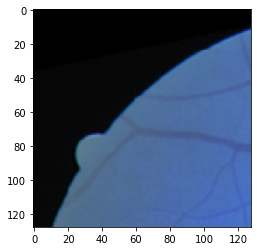

In [7]:
plt.imshow(orig_images[0])

In [8]:
masks=np.array([get_data_gif(path) for path in mask])
masks.shape

(900, 128, 128)

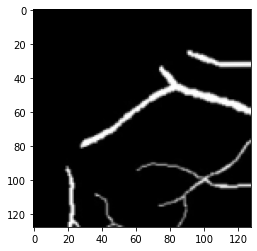

In [9]:
plt.imshow(masks[0],cmap='gray')

In [10]:
#orig_images = np.expand_dims(orig_images, axis = -1)
masks = np.expand_dims(masks, axis = -1)

In [11]:
masks.shape, orig_images.shape

((900, 128, 128, 1), (900, 128, 128, 3))

In [12]:
orig_images = orig_images / 255
masks = masks / 255

In [13]:
def get_unet():
    inputs = Input((128, 128, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
model = get_unet()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                 

In [15]:
model.fit(orig_images, masks, epochs = 10, batch_size= 8, shuffle = True, validation_split = 0.1)


Train on 810 samples, validate on 90 samples
Epoch 1/10
810/810 [==============================] - 74s 91ms/step - loss: 0.4634 - accuracy: 0.6734 - val_loss: 0.2937 - val_accuracy: 0.7031
Epoch 2/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3136 - accuracy: 0.6881 - val_loss: 0.2817 - val_accuracy: 0.7031
Epoch 3/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3086 - accuracy: 0.6881 - val_loss: 0.2802 - val_accuracy: 0.7031
Epoch 4/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3066 - accuracy: 0.6881 - val_loss: 0.2827 - val_accuracy: 0.7031
Epoch 5/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3058 - accuracy: 0.6881 - val_loss: 0.2820 - val_accuracy: 0.7031
Epoch 6/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3050 - accuracy: 0.6881 - val_loss: 0.2760 - val_accuracy: 0.7031
Epoch 7/10
810/810 [==============================] - 57s 70ms/step - loss: 0.3042 - accur